In [67]:
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import expr
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from helpers.helper_functions import translate_to_file_string
from pyspark.sql import DataFrameReader
from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, Normalizer, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from helpers.helper_functions import translate_to_file_string
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
# for pretty printing
def printDf(sprkDF): 
    newdf = sprkDF.toPandas()
    from IPython.display import display, HTML
    return HTML(newdf.to_html())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [68]:
inputFile = translate_to_file_string("../data/heart_val.csv")

In [69]:
spark = (SparkSession
       .builder
       .appName("HeartDiseaseAnalDT")
       .getOrCreate())

In [70]:
# load data file.
# create a DataFrame using an ifered Schema 
df = spark.read.option("header", "true") \
       .option("inferSchema", "true") \
       .option("delimiter", ";") \
       .csv(inputFile)
print(df.printSchema())

#Pandas df for visualization
dfp = df.toPandas()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: string (nullable = true)

None


In [71]:
#Show head
dfp.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,m,3,145,233,1,0,150,0,2.3,0,0,1,y
1,37,m,2,130,250,0,1,187,0,3.5,0,0,2,y
2,41,f,1,130,204,0,0,172,0,1.4,2,0,2,y
3,56,m,1,120,236,0,1,178,0,0.8,2,0,2,y
4,57,f,0,120,354,0,1,163,1,0.6,2,0,2,y


In [72]:
#Check for empty values
dfp.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [73]:
# Show summary of data
printDf(df.summary())

,summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,count,303,303,303,303,303,303,303,303,303,303,303,303,303,303
1,mean,54.366336633663366,None,0.966996699669967,131.62376237623764,246.26402640264027,0.1485148514851485,0.528052805280528,149.64686468646866,0.32673267326732675,1.0396039603960396,1.3993399339933994,0.7293729372937293,2.3135313531353137,None
2,stddev,9.08210098983786,None,1.0320524894832983,17.5381428135171,51.83075098793005,0.35619787492797644,0.525859596359298,22.90516111491409,0.46979446452231655,1.1610750220686346,0.6162261453459622,1.0226063649693276,0.6122765072781408,None
3,min,29,f,0,94,126,0,0,71,0,0.0,0,0,0,n
4,25%,47,None,0,120,211,0,0,133,0,0.0,1,0,2,None
5,50%,55,None,1,130,240,0,1,153,0,0.8,1,0,2,None
6,75%,61,None,2,140,275,0,1,166,1,1.6,2,1,3,None
7,max,77,m,3,200,564,1,2,202,1,6.2,2,4,3,y


In [74]:
#Show ages in bins
age_groups = pd.cut(dfp['age'], bins=[20, 30,40,50,60,70,80,90])
pd.crosstab(age_groups, dfp['sex'])

sex,f,m
age,,
"(20, 30]",0,1
"(30, 40]",5,13
"(40, 50]",22,54
"(50, 60]",35,94
"(60, 70]",29,44
"(70, 80]",5,1


Saving figure spread_of_age


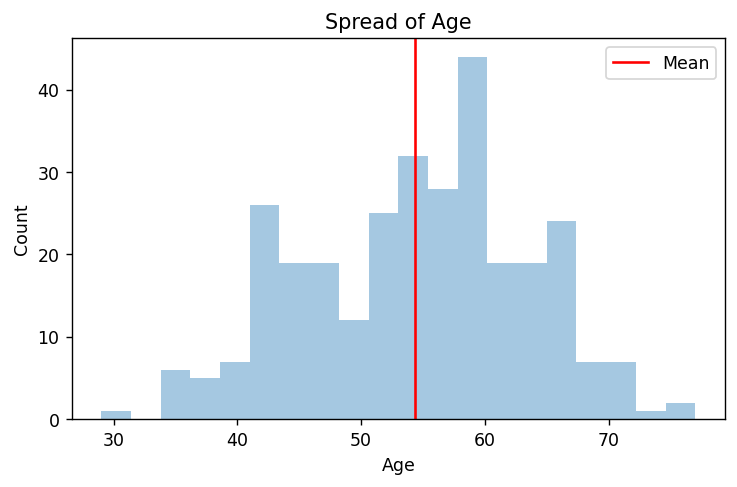

In [75]:
#Age visualization
plt.figure(dpi=125)
sns.distplot(a=dfp['age'],kde=False,bins=20)
plt.axvline(x=np.mean(dfp['age']),c='red',label='Mean')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Spread of Age')
save_fig("spread_of_age")
plt.show()

Saving figure overview_sex


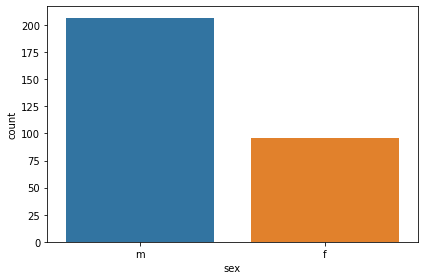

In [76]:
#Sex comparison m->male; f->female
dfp.sex.value_counts()
sns.countplot(dfp.sex)
save_fig("overview_sex")
plt.show()

Saving figure heart_diseas_sex


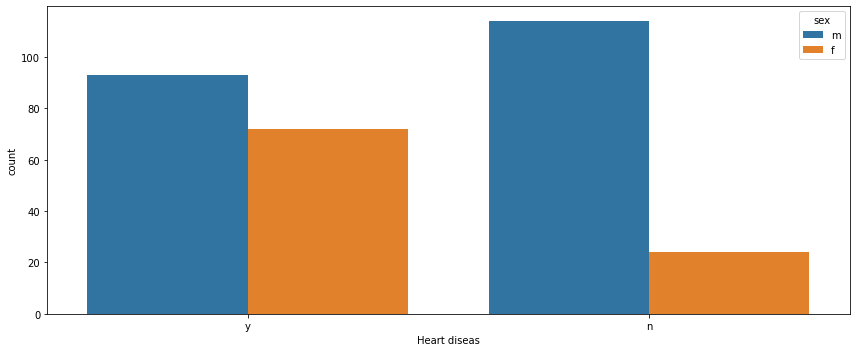

In [77]:
#Comparison  targets over sex
plt.figure(figsize=(12,5))
sns.countplot(dfp.target,hue=dfp.sex)
plt.xlabel('Heart diseas')
save_fig("heart_diseas_sex")
plt.show()

Saving figure attribute_box_plots


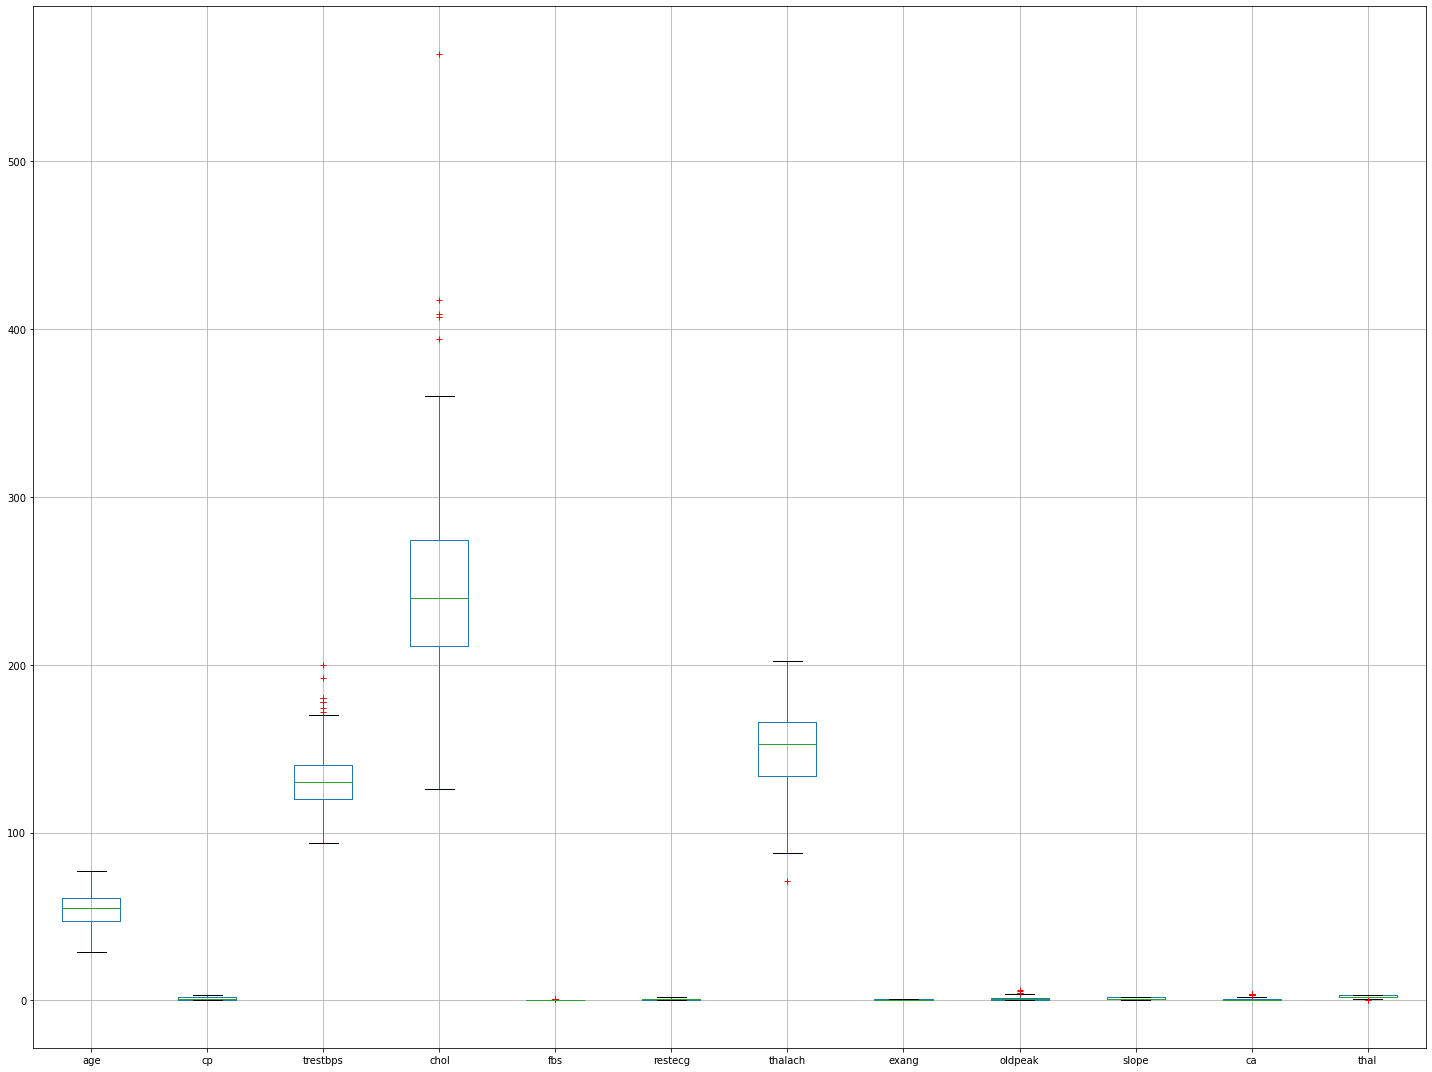

In [78]:

#Show all attributes in box plots
%matplotlib inline
df.toPandas().boxplot(sym='r+', figsize=(20,15))
save_fig("attribute_box_plots")
plt.show()

Saving figure overall_chest_pain


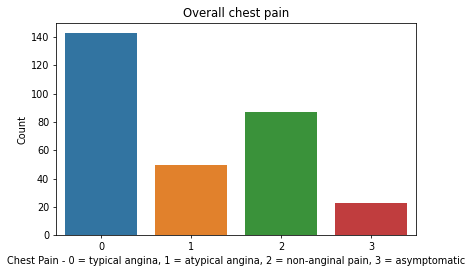

In [79]:
#Compare chestpain counts
plt.figure(dpi=70)
sns.countplot('cp',data = dfp,)
plt.xlabel('Chest Pain - 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic')
plt.ylabel('Count')
plt.title('Overall chest pain')
save_fig("overall_chest_pain")
plt.show()

Saving figure attribute_density_plots


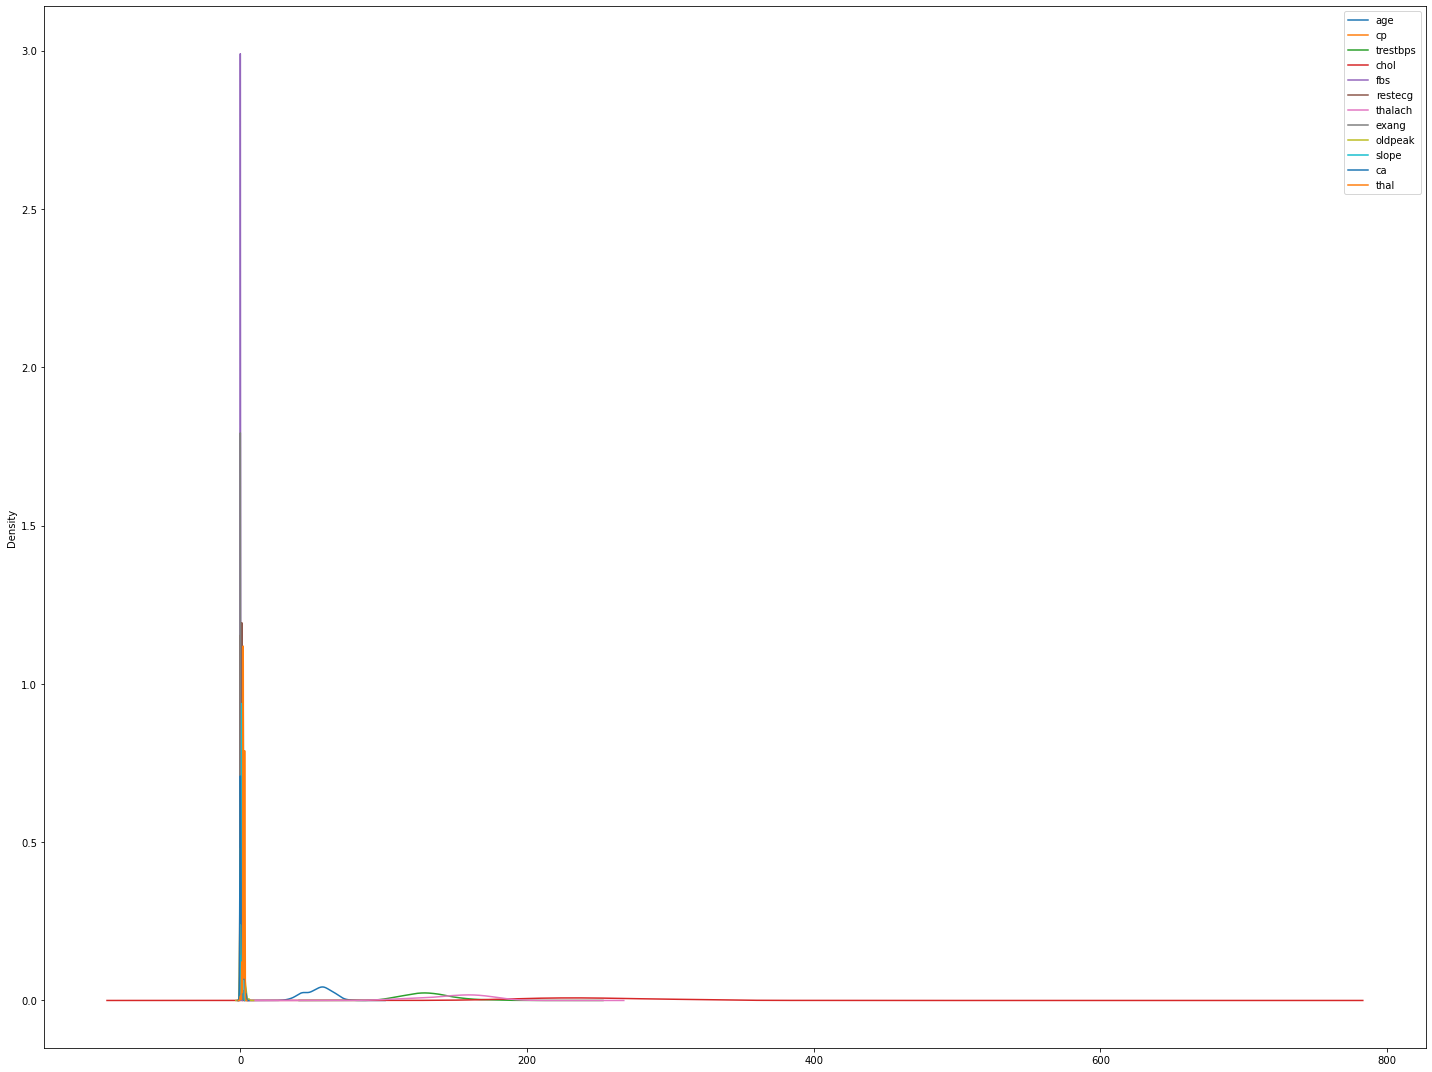

In [80]:
#Overall densitiy plot
%matplotlib inline
import matplotlib.pyplot as plt
df.toPandas().plot.kde(figsize=(20,15))
save_fig("attribute_density_plots")
plt.show()

Saving figure attribute_histogram_plots


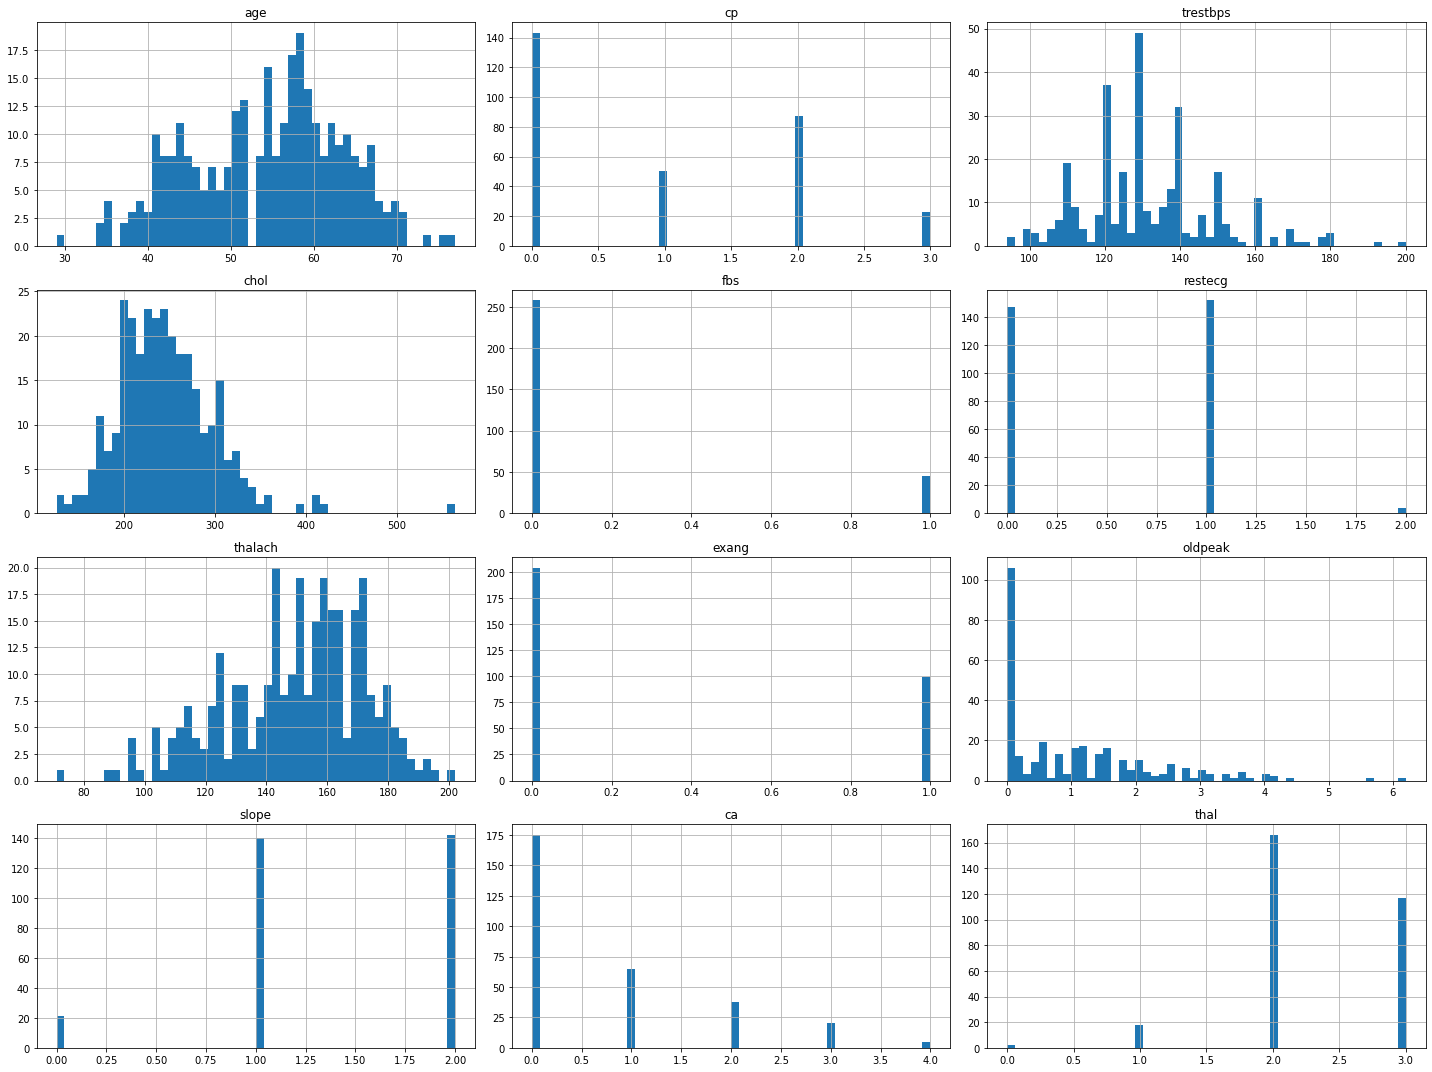

In [81]:
#Show histograms of each attribute
dfp.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

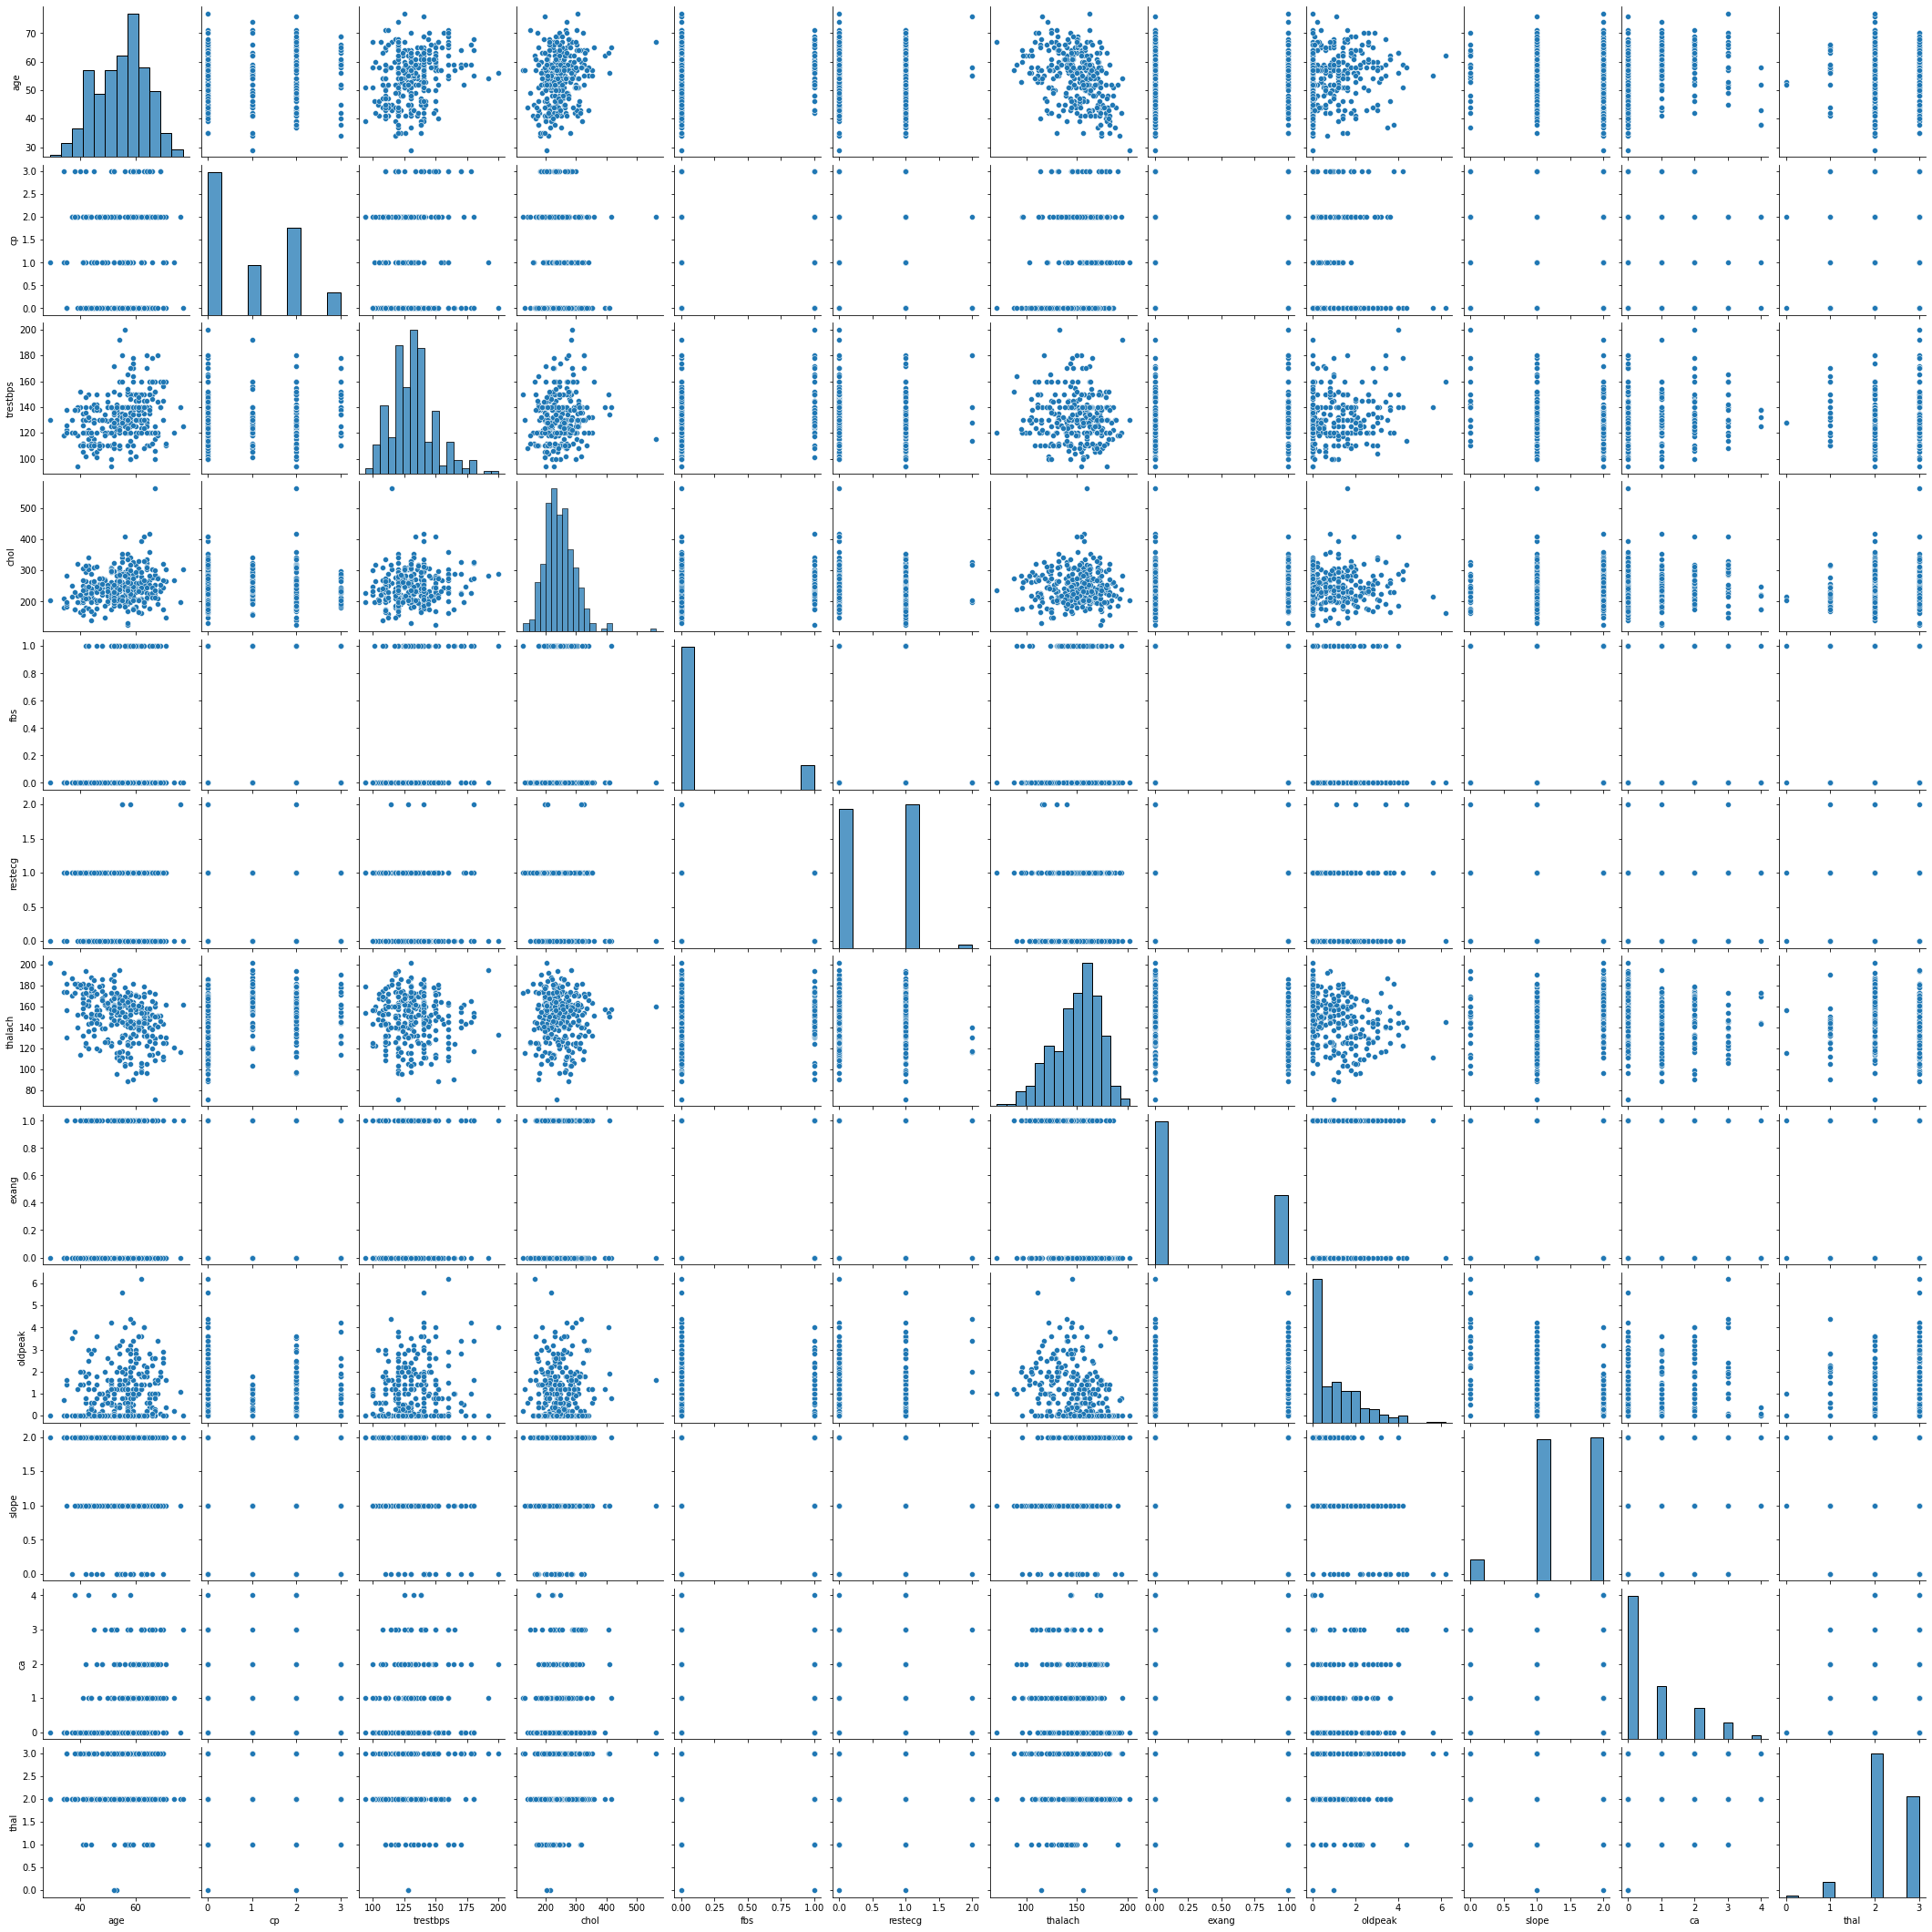

In [82]:
#Show all pairplots
sns.pairplot(data=dfp)

Saving figure overall_correlations


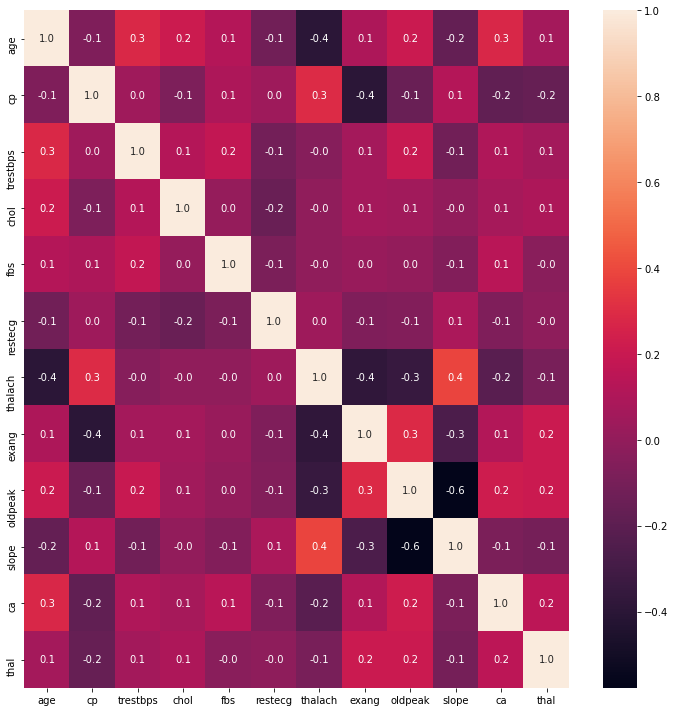

In [83]:
#Show all correlations via heatmap
plt.figure(figsize=(10,10))
sns.heatmap(dfp.corr(),annot=True,fmt='.1f')
save_fig("overall_correlations")
plt.show()

Saving figure chol_thalach_target_plot


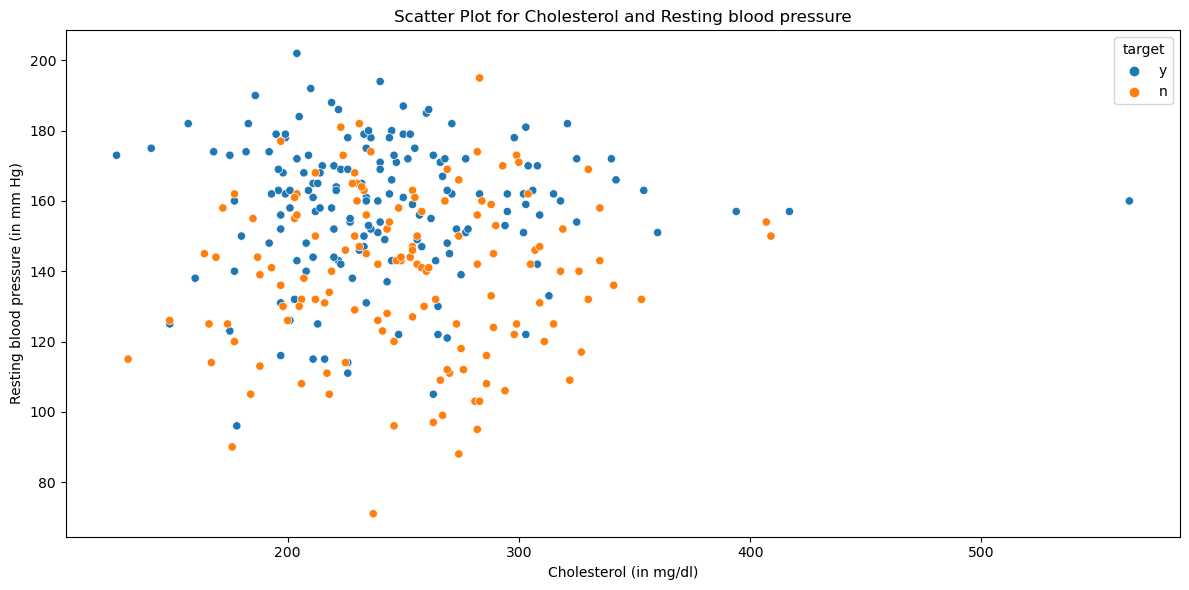

In [84]:
#Check for correaltions between cholesterol and blood pressure over targets
plt.figure(figsize=(12,6),dpi=100)
sns.scatterplot(x='chol',y='thalach',data=dfp,hue='target')
plt.xlabel('Cholesterol (in mg/dl)')
plt.ylabel('Resting blood pressure (in mm Hg)')
plt.title('Scatter Plot for Cholesterol and Resting blood pressure')
save_fig("chol_thalach_target_plot")
plt.show()

Saving figure age_cp_target_plot


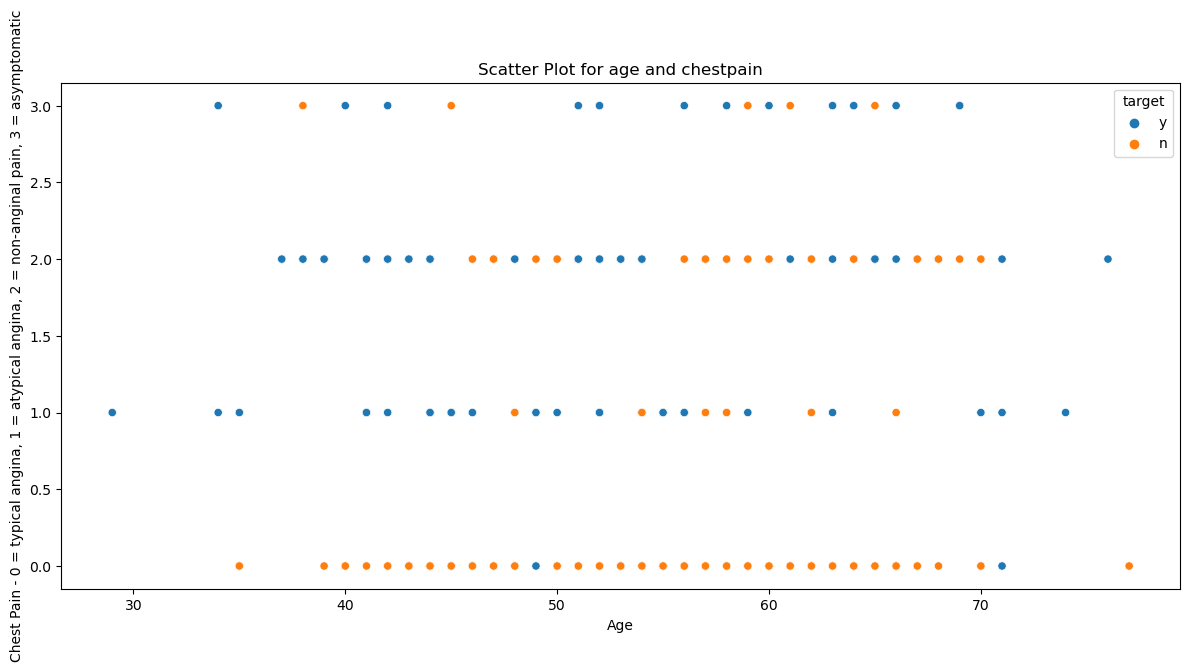

In [85]:
#Check correlation of age and chestpain
plt.figure(figsize=(12,6),dpi=100)
sns.scatterplot(x='age',y='cp',data=dfp,hue='target')
plt.xlabel('Age')
plt.ylabel('Chest Pain - 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic')
plt.title('Scatter Plot for age and chestpain')
save_fig("age_cp_target_plot")
plt.show()

Saving figure sex_thalach_target_plot


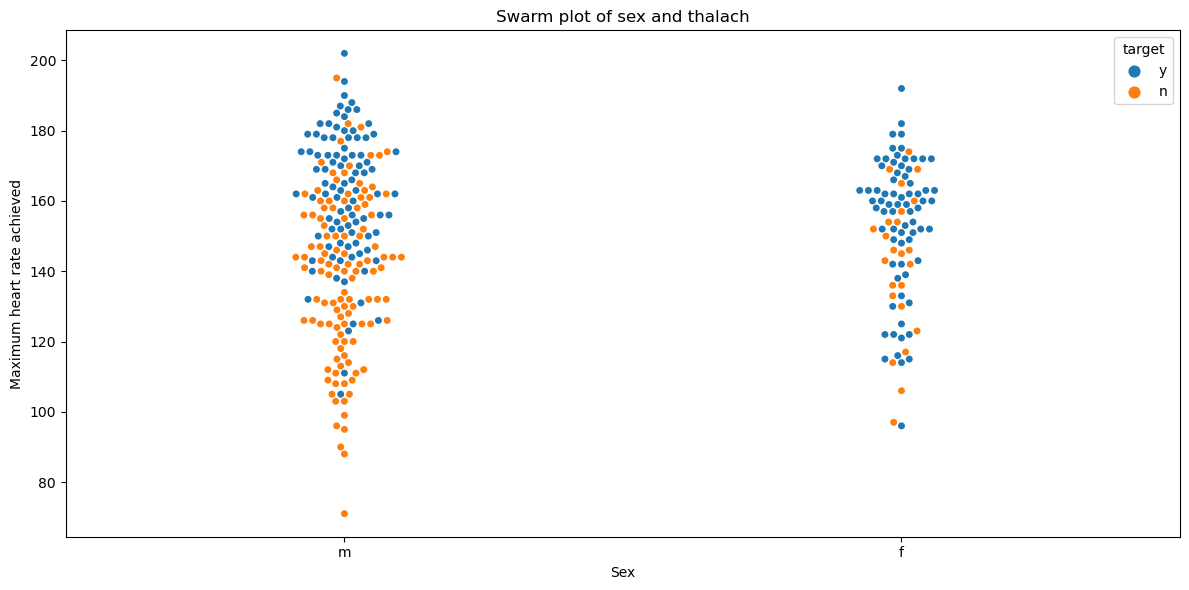

In [86]:
plt.figure(figsize=(12,6),dpi=100)
sns.swarmplot(x='sex',y='thalach',data=dfp,hue='target',dodge=False)
plt.xlabel('Sex')
plt.ylabel('Maximum heart rate achieved')
plt.title('Swarm plot of sex and thalach')
save_fig("sex_thalach_target_plot")
plt.show()

In [87]:
#Show all correlations in exact values
dfp.corr()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001
cp,-0.068653,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736
trestbps,0.279351,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210
chol,0.213678,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803
fbs,0.121308,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019
restecg,-0.116211,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981
thalach,-0.398522,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439
exang,0.096801,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754
oldpeak,0.210013,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244
slope,-0.168814,0.119717,-0.121475,-0.004038,-0.059894,0.093045,0.386784,-0.257748,-0.577537,1.000000,-0.080155,-0.104764


In [88]:
spark.stop()